**Значение ROC AUC на kaggle - 0.82472**

# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "./data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: total: 38.9 s
Wall time: 3.82 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [14]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [15]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-04_02-55-04.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [25]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

In [ ]:
cv_scores_rf

In [ ]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [16]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [17]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [18]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

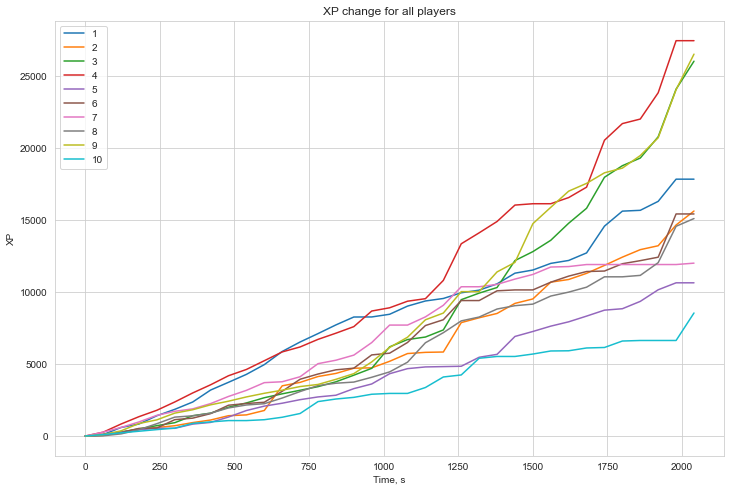

In [19]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [20]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [21]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [22]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [23]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [26]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 234 ms
Wall time: 30.4 s


In [27]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

### Попробуем поработать с признаками

Для начала, мне не очень нравится, что слишком много признаков. Думаю, какие-то можно попробовать объединить, чтобы это было не по признаку на каждого игрока, а один на команду. Кажется, что неплохо для этого подойдут xp, denies, lh, max_mana, stuns, creeps_stacked, towers_killed, roshans_killed, gold

In [28]:
def sum_features(df):
    feature_list = ['xp', 'gold', 'max_mana', 'denies', 'lh', 'stuns', 'creeps_stacked', 'towers_killed', 'roshans_killed']
    for i in feature_list:
        df[f'rsum_{i}'] = df[f'r1_{i}']+\
                          df[f'r2_{i}']+\
                          df[f'r3_{i}']+\
                          df[f'r4_{i}']+\
                          df[f'r5_{i}']
        for j in range(1,6):
            df = df.drop([f'r{j}_{i}'],axis=1)
        df[f'dsum_{i}'] = df[f'd1_{i}']+\
                          df[f'd2_{i}']+\
                          df[f'd3_{i}']+\
                          df[f'd4_{i}']+\
                          df[f'd5_{i}']
        for j in range(1,6):
            df = df.drop([f'd{j}_{i}'],axis=1)
    return df

In [29]:
df_train_processed = sum_features(df_train_features_extended)

In [145]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.78051340578097
CPU times: total: 46.9 ms
Wall time: 12.5 s


Супер!

А теперь колонки kills, deaths и assists превратим в одну - KDA.

In [30]:
def add_kda(df):
    for i in range(1,6):
        df[f'r{i}_kda'] = (df[f'r{i}_kills']+df[f'r{i}_assists'])/df[f'r{i}_deaths']
        df[f'r{i}_kda'] = df.apply(lambda row: row[f'r{i}_kills']+row[f'r{i}_assists'] \
            if pd.isnull(row[f'r{i}_kda']) or np.isinf(row[f'r{i}_kda']) \
            else row[f'r{i}_kda'], axis=1)

        df[f'd{i}_kda'] = (df[f'd{i}_kills']+df[f'd{i}_assists'])/df[f'd{i}_deaths']
        df[f'd{i}_kda'] = df.apply(lambda row: row[f'd{i}_kills']+row[f'd{i}_assists'] \
            if pd.isnull(row[f'd{i}_kda']) or np.isinf(row[f'd{i}_kda']) \
            else row[f'd{i}_kda'], axis=1)
    return df

In [31]:
def drop_kda(df):
    for i in range(1,6):
        df = df.drop([f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'], axis = 1)
        df = df.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths'], axis = 1)
    return df

In [32]:
df_train_processed = add_kda(df_train_processed)
df_train_processed = drop_kda(df_train_processed)

In [149]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7858094587384993
CPU times: total: 62.5 ms
Wall time: 11.2 s


Стало сильно лучше

А теперь посмотрим вообще на корреляцию признаков между собой

In [150]:
r1_df = df_train_processed.loc[:, df_train_processed.columns.str.contains(r"^r[sum1]+")]

<AxesSubplot:>

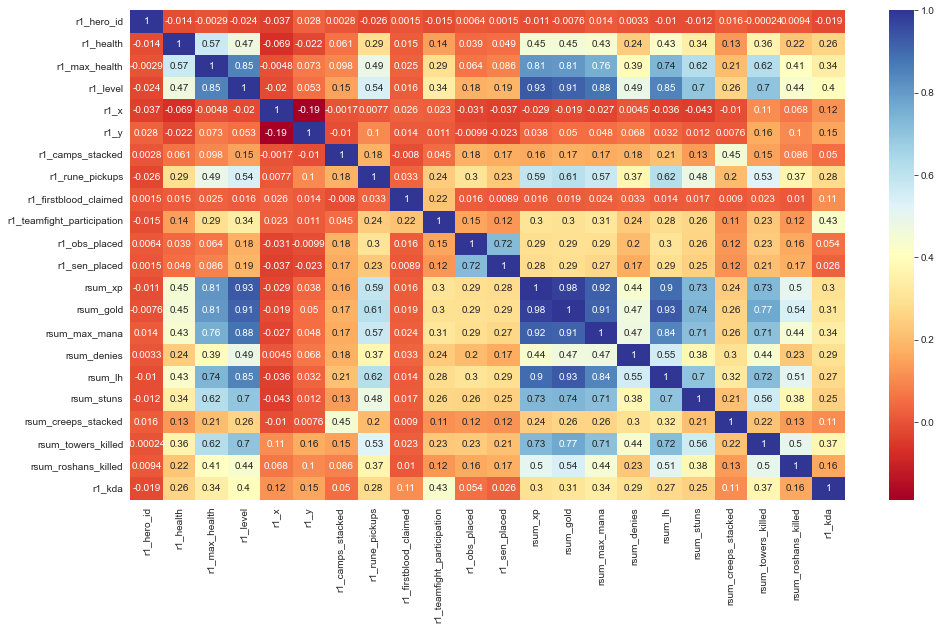

In [151]:
correlate = r1_df.corr()
plt.figure(figsize=(16,9))
sns.heatmap(correlate, cmap = 'RdYlBu', annot=True)

Cильно коррелируют между собой level, xp, gold, lh и mana. Что в целом, наверное, логично. Что если оставить только xp, а остальное убрать?

In [33]:
def remove_correlations(df):
    for i in range(1, 6):
        df = df.drop(f'r{i}_level', axis = 1)
        df = df.drop(f'd{i}_level', axis = 1)
    df = df.drop(['rsum_gold', 'rsum_lh', 'rsum_max_mana'], axis = 1)
    df = df.drop(['dsum_gold', 'dsum_lh', 'dsum_max_mana'], axis = 1)
    return df

In [34]:
df_test = remove_correlations(df_train_processed)

In [154]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_test.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7851524266181158
CPU times: total: 31.2 ms
Wall time: 10 s


Стало хуже :(
А если наоборот удалить только xp

In [155]:
def remove_xp(df):
    df = df.drop('rsum_xp', axis = 1)
    df = df.drop('dsum_xp', axis = 1)
    return df

In [156]:
df_test = remove_xp(df_train_processed)

In [157]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_test.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7854440154088518
CPU times: total: 46.9 ms
Wall time: 11.1 s


Неа, тоже не сработало. Ладно, оставлю как есть, пусть коррелируют дальше

А посмотрим вообще на feature importance

In [158]:
rf_model.fit(df_train_processed.values, y)
imp = rf_model.feature_importances_
feature_importance = pd.DataFrame({'importance': imp, 'feature': list(df_train_processed)}).set_index('feature')
features = feature_importance.sort_values('importance', ascending=True)

In [159]:
features.head()

,importance
feature,
d5_firstblood_claimed,0.000017
d1_firstblood_claimed,0.000022
r1_firstblood_claimed,0.000032
r5_firstblood_claimed,0.000046
d3_firstblood_claimed,0.000052


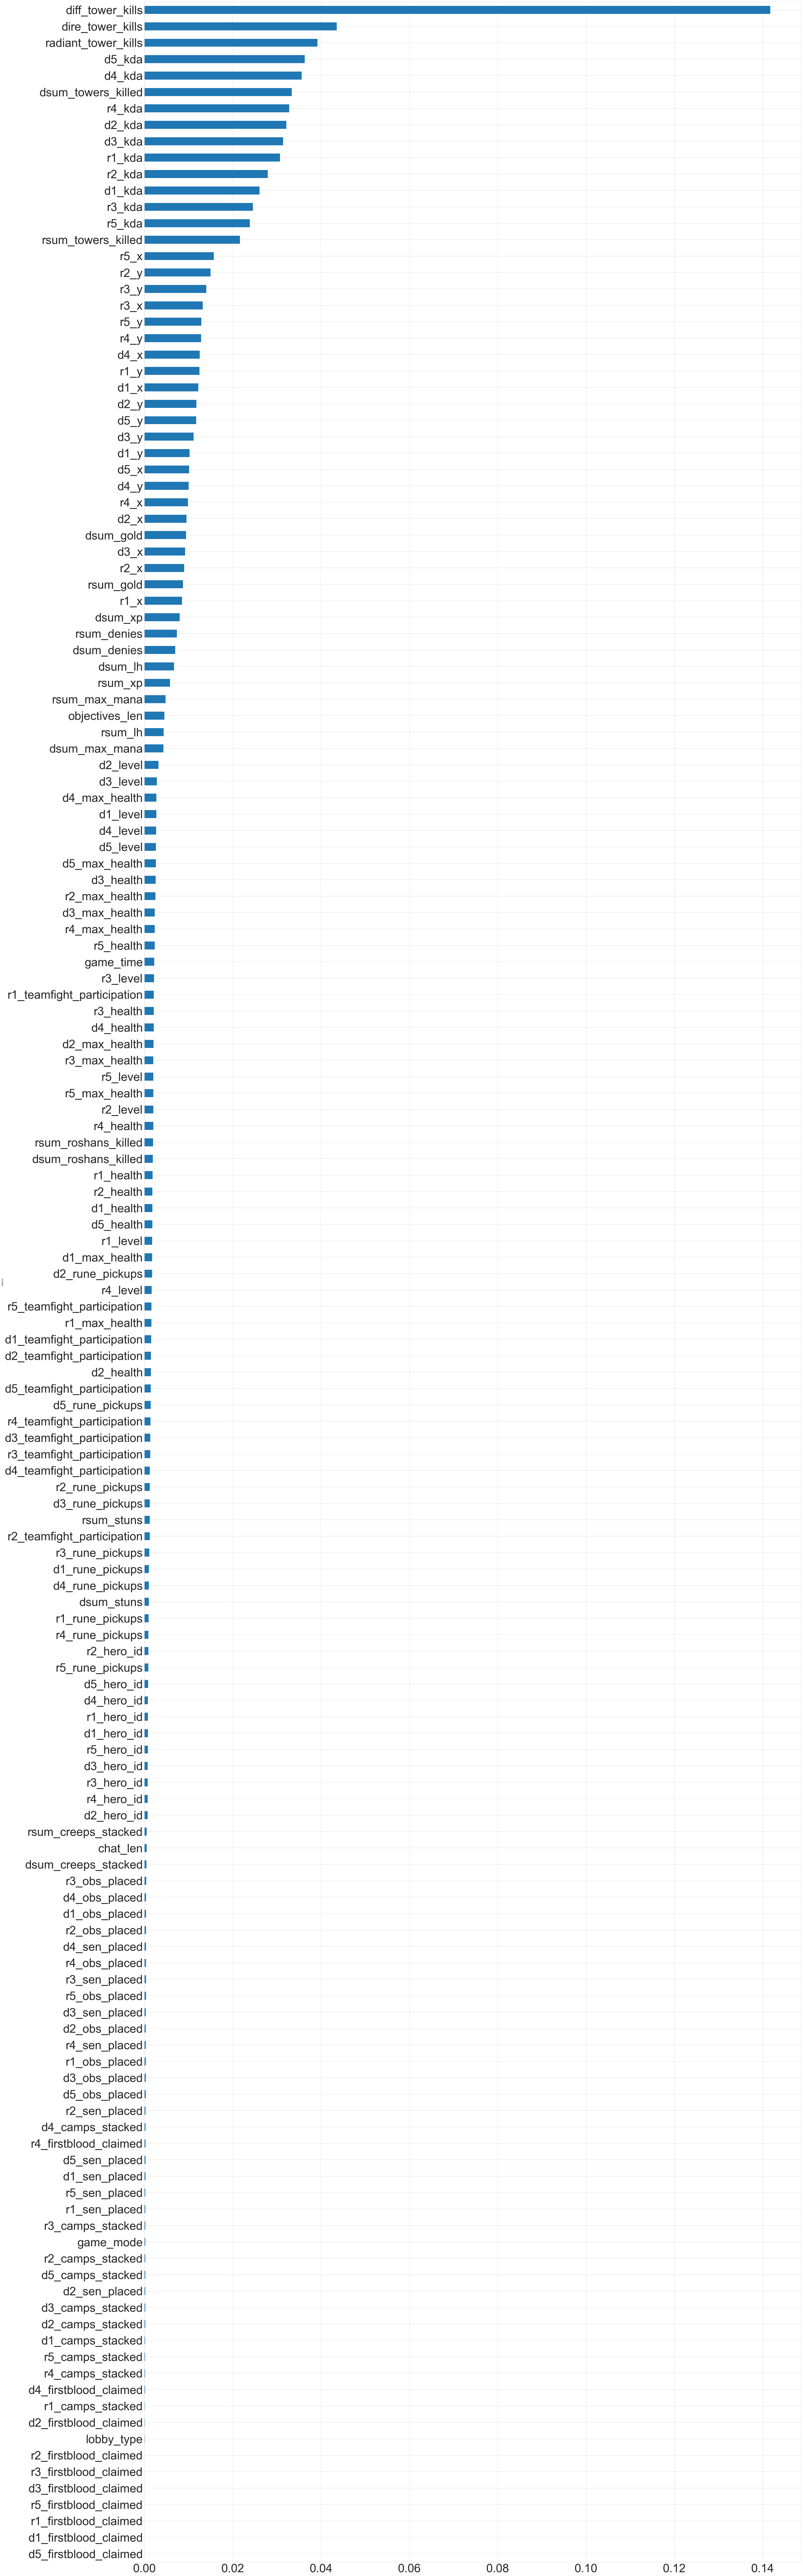

In [160]:
plt.figure(figsize=(50,200))
features.importance.plot(kind='barh')
plt.tick_params(axis='both', which='major', labelsize=50)
plt.show()

Кажется, что характеристики firstblood_claimed, camps_stacked и lobby_type не очень то значимы. А что если их не брать вообще? А еще san_placed, ods_paced, creeps_stacked, game_mode и chat_len

In [35]:
def remove_least_important(df):
    for i in range (1, 6):
        df = df.drop([f'r{i}_firstblood_claimed', f'r{i}_camps_stacked',
                      f'r{i}_sen_placed', f'r{i}_obs_placed'], axis = 1)
    for i in range(1, 6):
        df = df.drop([f'd{i}_firstblood_claimed', f'd{i}_camps_stacked',
                      f'd{i}_sen_placed', f'd{i}_obs_placed'], axis = 1)
    df = df.drop(["lobby_type", "game_mode", "chat_len",
                  "dsum_creeps_stacked", "rsum_creeps_stacked"], axis = 1)
    return df

In [36]:
df_test = remove_least_important(df_train_processed)

In [163]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_test.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7857591795487291
CPU times: total: 46.9 ms
Wall time: 10.5 s


In [37]:
df_train_processed = remove_least_important(df_train_processed)

А еще мне кажется что id не сильно важны, возможно я ошибаюсь. Проверим

In [42]:
def remove_id(df):
    for i in range(1, 6):
        df = df.drop(f'r{i}_hero_id', axis=1)
    for i in range(1, 6):
        df = df.drop(f'd{i}_hero_id', axis=1)
    return df

In [166]:
df_test = remove_id(df_train_processed)

In [167]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_test.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7855906718413316
CPU times: total: 31.2 ms
Wall time: 10.1 s


Стало немного хуже. Нужно подумать о преобразовании этих колонок. Потому что кажется, что численное представление героя может восприниматься алгоритмом как то, что чем больше цифра тем круче герой, хотя на самом деле это может быть совсем не так. А сколько их вообще, этих героев?

In [168]:
len(df_train_features_extended[f'd1_hero_id'].unique())

115

Сделаю отдельный датасет с id, поработаю с ним, потом добавлю его к основному

In [169]:
id_df = df_train_features_extended.filter(regex='hero_id')
id_df.head()

,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id
match_id_hash,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,15,96,27,63,89,58,14,1,56,92
6db558535151ea18ca70a6892197db41,101,51,44,49,53,18,67,47,40,17
19c39fe2af2b547e48708ca005c6ae74,57,10,81,98,119,48,68,60,102,8
c96d629dc0c39f0c616d1949938a6ba6,119,71,44,35,108,47,98,26,104,90
156c88bff4e9c4668b0f53df3d870f1b,12,49,91,114,50,51,47,48,119,68


Попробую предсказание только на этом датасете чтобы посмотреть как они вообще влияют и чтобы потом после преобразования можно было сравнивать

In [170]:
cv_scores_extended = cross_val_score(rf_model, id_df.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для id: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для id: 0.5211154620685636


Было бы здорово как-то по id героя уметь определять его успешность. Как это сделать - загадка. Для начала можно попробовать перевести все в строковый тип, чтобы величина числа не могла интерпретироваться как крутость героя. А потом сделаем one-hot-encoding, чтобы лес мог с этим работать. Не лучшее решение, наверное, потому что будет слишком много колонок, но попробуем. Вдруг сработает

In [171]:
id_df = id_df.astype('str')
id_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   r1_hero_id  31698 non-null  object
 1   r2_hero_id  31698 non-null  object
 2   r3_hero_id  31698 non-null  object
 3   r4_hero_id  31698 non-null  object
 4   r5_hero_id  31698 non-null  object
 5   d1_hero_id  31698 non-null  object
 6   d2_hero_id  31698 non-null  object
 7   d3_hero_id  31698 non-null  object
 8   d4_hero_id  31698 non-null  object
 9   d5_hero_id  31698 non-null  object
dtypes: object(10)
memory usage: 3.7+ MB


In [172]:
id_list = id_df[f'd1_hero_id'].unique()
id_list

array(['58', '18', '48', '47', '51', '75', '4', '2', '6', '111', '49',
       '81', '28', '90', '22', '114', '88', '7', '104', '41', '14', '40',
       '27', '62', '119', '21', '64', '32', '68', '76', '102', '23', '99',
       '72', '112', '39', '69', '45', '19', '8', '1', '113', '9', '30',
       '5', '95', '25', '107', '94', '108', '42', '65', '60', '26', '46',
       '15', '33', '34', '16', '11', '93', '71', '83', '67', '97', '37',
       '35', '120', '85', '36', '10', '84', '92', '101', '57', '17', '77',
       '109', '50', '74', '53', '86', '44', '54', '82', '63', '98', '61',
       '100', '31', '13', '56', '105', '110', '87', '96', '70', '12',
       '52', '89', '3', '43', '80', '29', '91', '73', '20', '106', '38',
       '66', '59', '79', '78', '103', '55'], dtype=object)

In [173]:
id_onehot = pd.get_dummies(id_df)
id_onehot.head()

,r1_hero_id_1,r1_hero_id_10,r1_hero_id_100,r1_hero_id_101,r1_hero_id_102,r1_hero_id_103,r1_hero_id_104,r1_hero_id_105,r1_hero_id_106,r1_hero_id_107,...,d5_hero_id_90,d5_hero_id_91,d5_hero_id_92,d5_hero_id_93,d5_hero_id_94,d5_hero_id_95,d5_hero_id_96,d5_hero_id_97,d5_hero_id_98,d5_hero_id_99
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6db558535151ea18ca70a6892197db41,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
156c88bff4e9c4668b0f53df3d870f1b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


А еще можно учесть тот факт, что, наверное, не важно к какому конкретно игроку относится герой, важно только то что он есть в команде. И в команде не может быть двух одинаковых игроков. Поэтому можно просуммировать по командам, чтобы таблица была чуть меньше. И сделаю из всего этого функцию с самого начала, чтобы потом ее можно было легко применять.

In [38]:
def one_hot_encoding(df):
    '''
    Внутри функции колонки преобразуются в строковый тип, сделается one_hot_encoding и просуммируются по героям
    Args:
        df: датафрейм только с колонками _hero_id
    '''
    df = df.astype('str')
    hero_list = list(df[f'd1_hero_id'].unique())
    df = pd.get_dummies(df)
    for i in hero_list:
        df[f'rhero_{i}'] = df.filter(regex=f'r[1-5]+_hero_id_{i}').sum(axis = 1)
        df = df.drop(df.filter(regex=f'r[1-5]+_hero_id_{i}').columns, axis = 1)
        df[f'dhero_{i}'] = df.filter(regex=f'd[1-5]+_hero_id_{i}').sum(axis = 1)
        df = df.drop(df.filter(regex=f'd[1-5]+_hero_id_{i}').columns, axis = 1)
    return df

In [175]:
id_df = one_hot_encoding(id_df)

In [176]:
id_df.head()

,rhero_58,dhero_58,rhero_18,dhero_18,rhero_48,dhero_48,rhero_47,dhero_47,rhero_51,dhero_51,...,rhero_59,dhero_59,rhero_79,dhero_79,rhero_78,dhero_78,rhero_103,dhero_103,rhero_55,dhero_55
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6db558535151ea18ca70a6892197db41,0,0,0,1,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,0,0,0,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


А еще надо проверить вдруг у нас теперь есть колонки в которых ни одной единицы. Их можно удалить.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

zeros = VarianceThreshold(threshold=0)
zeros.fit(id_df)

In [178]:
sum(zeros.get_support())

72

Ого, останется всего 72 колонки из 230 с ненулевыми значениями! Конечно надо почистить

In [179]:
id_df_final = id_df[[x for x in id_df.columns if x in id_df.columns[zeros.get_support()]]]

In [180]:
id_df_final.head()

,rhero_58,dhero_58,rhero_18,dhero_18,rhero_48,dhero_48,rhero_47,dhero_47,rhero_51,dhero_51,...,rhero_37,dhero_37,rhero_35,dhero_35,rhero_36,dhero_36,rhero_31,dhero_31,rhero_3,dhero_3
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6db558535151ea18ca70a6892197db41,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
156c88bff4e9c4668b0f53df3d870f1b,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Попробуем теперь посмотреть что будет с моделью

In [181]:
cv_scores_extended = cross_val_score(rf_model, id_df_final.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для id: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для id: 0.5621374497828862


А вообще неплохо получилось. Попробую теперь собрать это все в одну большую функцию, которая уберет из основного датафрейма id, преобразует их и склеит все обратно

In [40]:
def transform_ids(full_df):
    # забираем айдишники в отдельный датафрейм
    id_df = full_df.filter(regex='hero_id')
    # удаляем айдишники
    full_df = remove_id(full_df)
    # преобразуем айдишники
    id_df = one_hot_encoding(id_df)
    zeros = VarianceThreshold(threshold=0)
    zeros.fit(id_df)
    id_df_final = id_df[[x for x in id_df.columns
                         if x in id_df.columns[zeros.get_support()]]]

    # склеиваем
    final_df = pd.concat([full_df, id_df], axis = 1)
    return final_df

In [183]:
df_test = transform_ids(df_train_processed)

In [184]:
cv_scores_extended = cross_val_score(rf_model, df_test.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для датасета с измененными id: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для датасета с измененными id: 0.7865913067125626


Окей, немного лучше.

In [43]:
df_train_processed = transform_ids(df_train_processed)

### А теперь попробуем другие алгоритмы кроме RF

**Бустинг**

In [186]:
import lightgbm

In [187]:
boosting = lightgbm.LGBMClassifier()

In [188]:
cv_scores_extended = cross_val_score(boosting, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для бустинга: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для бустинга: 0.8046402673599605


Вау, 0.8!

Я сейчас ожидаю низкий скор, но просто интересно, что скажут разные простые классификаторы.

**KNN**

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.preprocessing import StandardScaler

In [190]:
kclassif = KNeighborsClassifier(n_neighbors=10)

In [191]:
cv_scores_extended = cross_val_score(kclassif, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для KNN: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для KNN: 0.7771798488821517


**Линейная регрессия**

In [192]:
linreg = LinearRegression()

In [193]:
cv_scores_extended = cross_val_score(linreg, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для линейной регрессии: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для линейной регрессии: 0.8136179250190313


Неожиданно с линейной регрессией! А если еще и со стандартизацией попробовать

In [194]:
scaler = StandardScaler()
df_train_processed_scaled = scaler.fit_transform(df_train_processed)

In [195]:
cv_scores_extended = cross_val_score(linreg, df_train_processed_scaled, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для линейной регрессии: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для линейной регрессии: 0.8136151810625514


Лучше не стало. Для линейной регрессии лучше все-таки удалить коррелирующие переменные

In [196]:
df_train_linregression = remove_correlations(df_train_processed)
df_train_linregression_scaled = scaler.fit_transform(df_train_linregression)

In [197]:
cv_scores_extended = cross_val_score(linreg, df_train_linregression.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для KNN: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для KNN: 0.8085848535094933


Ухудшилось :(

**Логистическая регрессия**

In [46]:
logreg = LogisticRegression(max_iter=10000)

In [48]:
logreg.fit(df_train_processed.values, y)

LogisticRegression(max_iter=10000)

In [200]:
cv_scores_extended = cross_val_score(logreg, df_train_processed_scaled, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для логистической регрессии: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для логистической регрессии: 0.8172732471510097


Ого, еще круче! Снова попробую стандартизацию и удаление коррелирующих

In [201]:
cv_scores_extended = cross_val_score(logreg, df_train_linregression_scaled, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для логистической регрессии: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для логистической регрессии: 0.8120254949480653


:(

А теперь попробую из всего что у меня есть собрать Voting classifier

In [202]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

In [203]:
voting_model = [('RF', rf_model),
                ('Boost', boosting),
                ('KNN', kclassif),
                ('LOG', logreg)]
voting = VotingClassifier(voting_model, voting='soft')

In [204]:
cv_scores_extended = cross_val_score(voting, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для voting classifier: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для voting classifier: 0.8128635839179822


Грустно как-то...

In [205]:
voting_model = [('RF', rf_model),
                ('Boost', boosting),
                # ('KNN', kclassif),
                ('LOG', logreg)]
voting = VotingClassifier(voting_model, voting='soft')

In [206]:
cv_scores_extended = cross_val_score(voting, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для voting classifier: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для voting classifier: 0.8115620268383814


Ага, если убирать одну модель даже с самым низким скором, то качество ухудшается. Тогда попробуем наоборот подобавлять

In [57]:
from sklearn.tree import DecisionTreeClassifier
import catboost
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost

In [58]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
nb = GaussianNB()
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)

In [209]:
# voting_model = [('RF', rf_model),
#                 ('Boost', boosting),
#                 ('KNN', kclassif),
#                 ('XGB', xgb),
#                 ('Cat', cat),
#                 ('NB', nb),
#                 ('SVC', svc_rbf),
#                 ('DT', dt)]
# voting = VotingClassifier(voting_model, voting='soft')

In [ ]:
# cv_scores_extended = cross_val_score(voting, df_train_processed.values, y,
#                                      cv=cv, scoring="roc_auc", n_jobs=-1)
# print(f"ROC-AUC на кросс-валидации для voting classifier: {cv_scores_extended.mean()}")

В общем эта штука работала у меня почти полтора часа но так и не доработала :(

Попробую тогда все модели по отдельности и запущу voting classifier только на тех, где roc-auc наибольшая

In [59]:
models = [cat, xgb, nb, dt]
for model in models:
    cv_scores_extended = cross_val_score(model, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"ROC-AUC на кросс-валидации для {model}: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для <catboost.core.CatBoostClassifier object at 0x00000196C8C0EE50>: 0.810765735241566
ROC-AUC на кросс-валидации для XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10801, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None): 0.7938825325486965
ROC-AUC на кросс-валидации для GaussianNB(): 0.7701628754578419
ROC-AUC на кросс-валидации для DecisionTreeClassifier(max_depth=10, min_samples_leaf

Там у меня на svc все зависло несколько раз, поэтому его вообще убрала. Попробую взять несколько моделей и все-таки сделать voting

In [ ]:
voting_model = [('Boost', boosting),
                ('LOG', logreg),
                ('Cat', cat),
                ('RF', rf_model)]
voting = VotingClassifier(voting_model, voting='soft')

In [ ]:
cv_scores_extended = cross_val_score(voting, df_train_processed.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для voting classifier: {cv_scores_extended.mean()}")

В общем скор все равно меньше чем некоторые из тех, что получены ранее

Новых идей у меня больше нет, лучшее что у меня получилось - скор на логистической регрессии. Эту модель и возьму для предсказания на тесте.

# Повторяем все на test

In [49]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

In [50]:
df_test_features.shape

(7977, 245)

In [51]:
def read_matches(matches_file, total_matches=7977, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

In [52]:
# Скопируем таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "test_raw_data.jsonl"))

  0%|          | 0/7977 [00:00<?, ?it/s]

In [53]:
df_test_processed = sum_features(df_test_features_extended)
df_test_processed = add_kda(df_test_processed)
df_test_processed = drop_kda(df_test_processed)
df_test_processed = remove_least_important(df_test_processed)
df_test_processed = transform_ids(df_test_processed)

### Посылка

In [54]:
X_test = df_test_processed.values
y_test_pred = logreg.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [55]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-04_03-04-28.csv


В конце хочу сказать огромное спасибо за такое задание! Хоть у меня и не получился супер хороший скор, мне было очень интересно участвовать в соревновании (даже несмотря на то, что я никогда не играла в доту). В какой-то момент у меня был азарт, мне кажется, не меньше, чем у самих игроков! Было здорово придумывать что можно сделать, чтобы улучшать предсказания. Сразу всё, что было изучено в курсе, собралось в одну общую картинку в голове!